In [59]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

### Functions used in this Homework

In [118]:
def model_summary(y_true, y_pred, prob):
    print("Confusion Matrix:\n")
    print(confusion_matrix(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    
    print("\nThe misclassification in the set:",(fp+fn))
    
    fpr, tpr, thresholds = roc_curve(y_true, prob)
    area = auc(fpr, tpr)
    
    print("\nArea under the curve:",area)
    print("\nThe accuracy score:",accuracy_score(y_true,y_pred))
    print("\nThe error obtained:",1 - accuracy_score(y_true,y_pred))
    
    label_="ROC Curve : area = {} ".format(round(area, 4))
    plt.plot(fpr, tpr, label=label_)
    plt.plot([0,1],[0,1])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC AUC Curve")
    plt.legend()
    
def to_String_label(df):
    df.loc[df['class']==0,'class']='neg'
    df.loc[df['class']==1,'class']='pos'
    return df

def to_Numeric_label(df):
    df.loc[df['class']=='neg','class']=0
    df.loc[df['class']=='pos','class']=1
    df = df.astype('int')
    return df

### 1. The LASSO and Boosting for Regression

### (a) Download the Communities and Crime data. Use the first 1495 rows of data as the training set and the rest as the test set.

#### Reading attributes from communities.names

In [60]:
header = []
with open("../Data/communities.names","r") as f:
    for line in f:
        if line.startswith('@attribute'):
            header.append(line.split(" ")[1])
header

['state',
 'county',
 'community',
 'communityname',
 'fold',
 'population',
 'householdsize',
 'racepctblack',
 'racePctWhite',
 'racePctAsian',
 'racePctHisp',
 'agePct12t21',
 'agePct12t29',
 'agePct16t24',
 'agePct65up',
 'numbUrban',
 'pctUrban',
 'medIncome',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'medFamInc',
 'perCapInc',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'OtherPerCap',
 'HispPerCap',
 'NumUnderPov',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctNotHSGrad',
 'PctBSorMore',
 'PctUnemployed',
 'PctEmploy',
 'PctEmplManu',
 'PctEmplProfServ',
 'PctOccupManu',
 'PctOccupMgmtProf',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'TotalPctDiv',
 'PersPerFam',
 'PctFam2Par',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctWorkMomYoungKids',
 'PctWorkMom',
 'NumIlleg',
 'PctIlleg',
 'NumImmig',
 'PctImmigRecent',
 'PctImmigRec5',
 'PctImmigRec8',
 'PctImmigRec10',
 'PctRecentImmig',
 'P

#### Load data from communities.csv 

In [61]:
df = pd.read_csv("../Data/communities.csv", header=None)
df.columns = header
df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


#### Split train and test data

#### Train dataset

In [62]:
train_df = df.loc[0:1494,:]
train_df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,6,?,?,Hillsboroughtown,8,0.00,0.59,0.01,0.69,1.00,...,0.02,0.14,0.22,?,?,?,?,0.00,?,0.03
1491,6,?,?,Orangecity,8,0.16,0.62,0.03,0.74,0.48,...,0.07,0.40,0.14,0.07,0.05,0.85,0.5,0.61,0.19,0.20
1492,13,?,?,Waycrosscity,8,0.01,0.36,0.95,0.24,0.03,...,0.03,0.12,0.01,?,?,?,?,0.00,?,0.30
1493,39,85,49056,Mentorcity,8,0.06,0.53,0.01,0.98,0.05,...,0.08,0.15,0.02,?,?,?,?,0.00,?,0.03


#### Test dataset

In [63]:
test_df = df.loc[1495:,:]
test_df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
1495,6,?,?,MillValleycity,8,0.00,0.20,0.03,0.91,0.23,...,0.01,0.23,0.73,?,?,?,?,0.00,?,0.12
1496,48,?,?,LiveOakcity,8,0.00,0.55,0.13,0.78,0.15,...,0.01,0.18,0.02,?,?,?,?,0.00,?,0.11
1497,35,?,?,Portalescity,8,0.00,0.52,0.04,0.59,0.05,...,0.01,0.18,0.00,?,?,?,?,0.00,?,0.12
1498,42,17,25112,Fallstownship,8,0.04,0.51,0.07,0.92,0.09,...,0.06,0.13,0.16,?,?,?,?,0.00,?,0.06
1499,51,683,48952,Manassascity,8,0.03,0.59,0.20,0.75,0.19,...,0.03,0.23,0.06,?,?,?,?,0.00,?,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

#### Removing non-predictive features

In [64]:
pred_df = df.iloc[:,5:]
pred_df

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [65]:
# Converting ? to nan values

imp_df = pred_df.replace('?',np.nan)
missing_col_idx = imp_df.columns[imp_df.isnull().any()]
print('\033[1m'+"There are missing values in these columns: \n"+'\033[0m')
print(missing_col_idx,"\n")

# Count of missing values in each column

print('\033[1m'+"Count of missing values in each column: \n"+'\033[0m')
print(imp_df[missing_col_idx].isna().sum())

There are missing values in these columns: 

Index(['OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
       'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop',
       'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol',
       'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian',
       'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
       'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'PolicBudgPerPop'],
      dtype='object') 

Count of missing values in each column: 

OtherPerCap                1
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675


#### Imputing data in only OtherPerCap column as other columns have a lot of missing values (more than 80% values are missing) and dropping those columns

In [66]:
col = 'OtherPerCap'
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(imp_df[[col]])
imp_df[[col]] = imputer.transform(imp_df[[col]])

# Droping the columns that has large number of missing values (more than 80% values missing)

imp_df = imp_df.dropna(axis=1)
imp_df

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


In [67]:
X_df = imp_df.drop(imp_df.columns[-1],axis=1)
y_df = imp_df[imp_df.columns[-1]]
print(X_df.shape)
print(y_df.shape)

(1994, 100)
(1994,)


#### Imputed train and test datasets

In [68]:
imp_train_df = imp_df.loc[0:1494,:]
imp_train_df

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.61,0.46,0.75,0.72,0.78,0.02,0.14,0.22,0.00,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.60,0.44,0.39,0.68,0.67,0.07,0.40,0.14,0.61,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.02,0.86,0.61,0.77,0.81,0.03,0.12,0.01,0.00,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.78,0.63,0.70,0.82,0.08,0.15,0.02,0.00,0.03


In [69]:
imp_test_df = imp_df.loc[1495:,:]
imp_test_df

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
1495,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.33,0.45,0.57,0.56,0.74,0.01,0.23,0.73,0.00,0.12
1496,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.17,0.45,0.52,0.59,0.57,0.01,0.18,0.02,0.00,0.11
1497,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.19,0.47,0.37,0.38,0.49,0.01,0.18,0.00,0.00,0.12
1498,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.10,0.62,0.70,0.75,0.64,0.06,0.13,0.16,0.00,0.06
1499,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.22,0.33,0.16,0.06,0.27,0.03,0.23,0.06,0.00,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


After removing non-predictive columns and data imputation, there are only 101 columns (100 features and 1 response) left in the dataset out of 128 columns in the beginning. I have used mean to do data imputation for "OtherPerCap" column.

### (c) Plot a correlation matrix for the features in the data set.

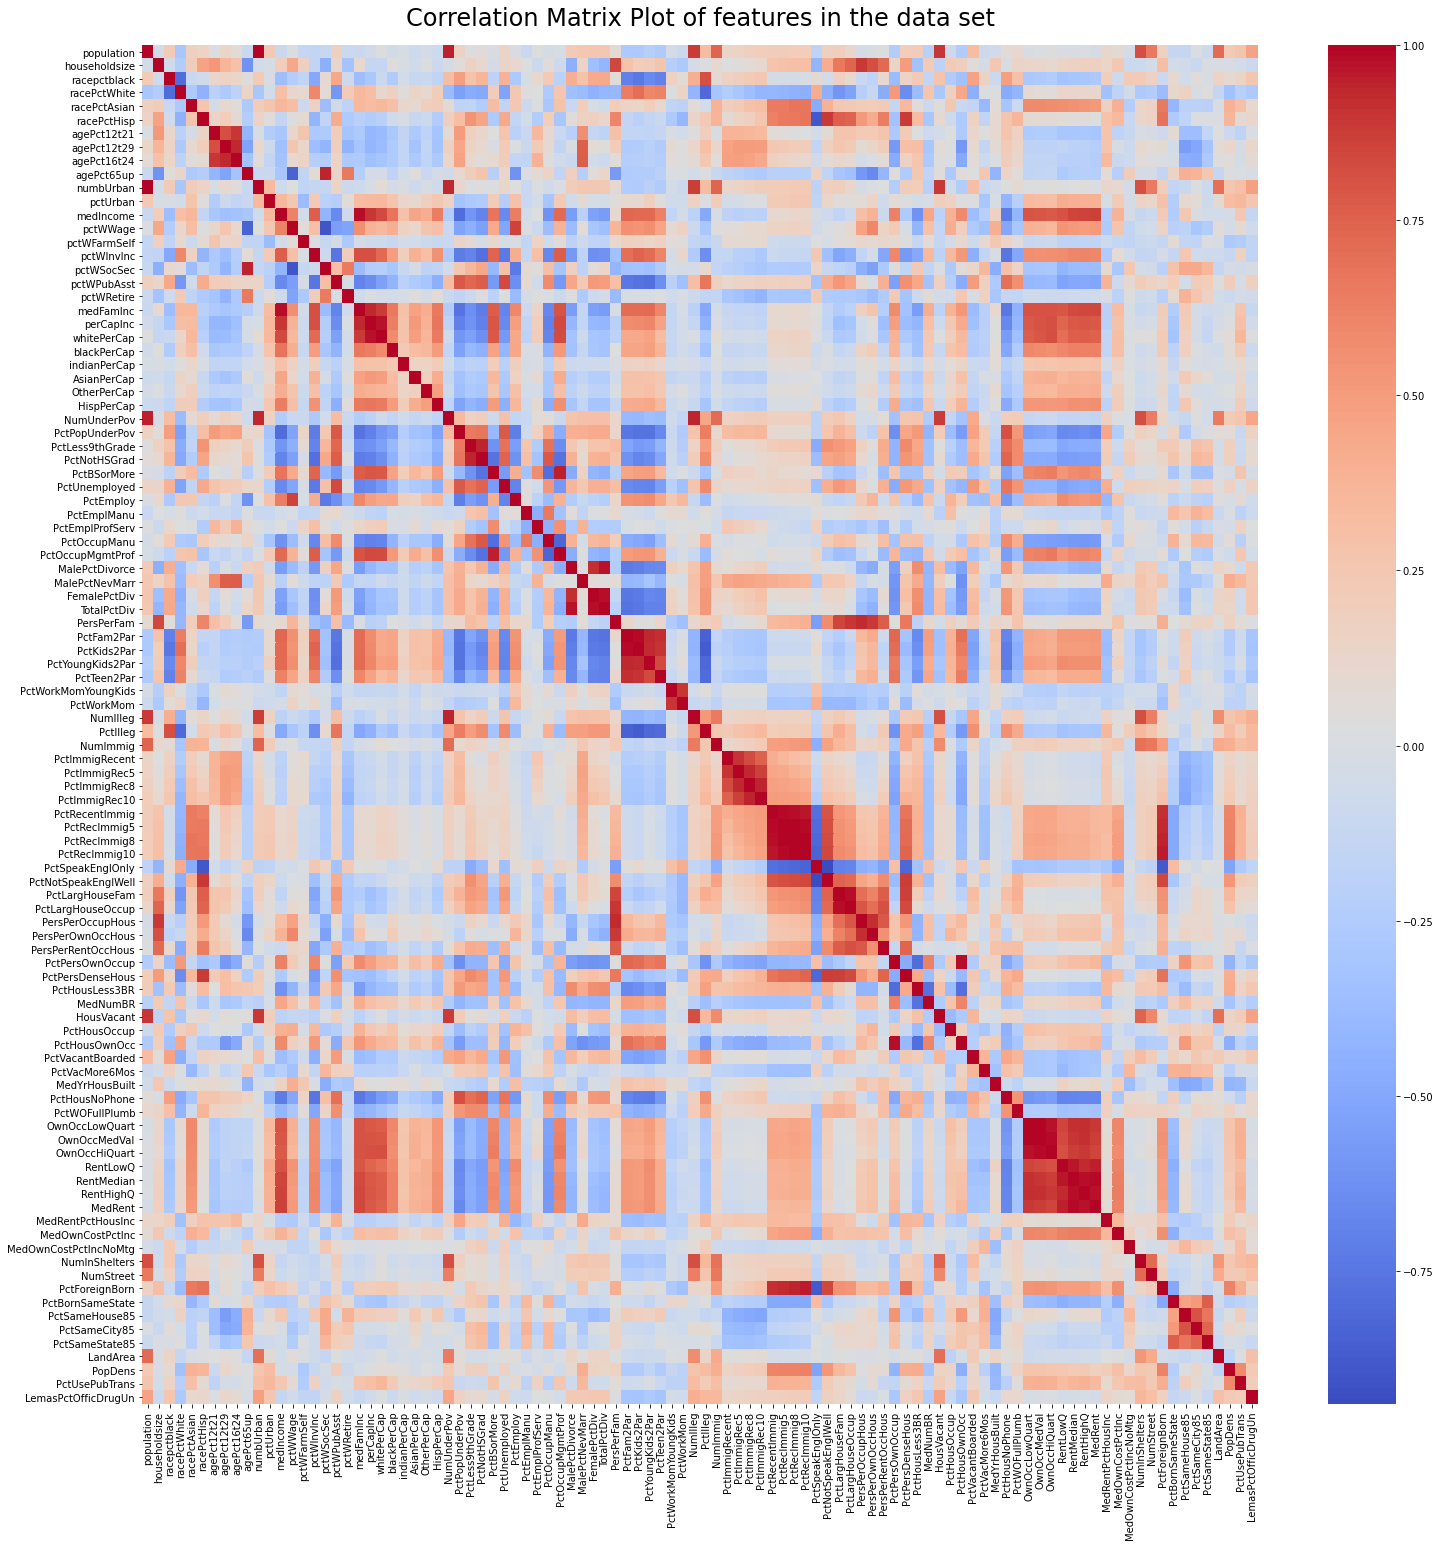

In [70]:
cor_mtx = X_df.corr()
fig = plt.figure(figsize=(25, 25))
sns.heatmap(cor_mtx, xticklabels=cor_mtx.columns, yticklabels=cor_mtx.columns, cmap='coolwarm')
plt.title("Correlation Matrix Plot of features in the data set",y=1.01,fontsize=24)
plt.show()

### (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in which s is sample standard deviation and m is sample mean.

In [71]:
cv =  lambda x: np.std(x) / np.mean(x)
cv_result = X_df.apply(cv,axis=0)
print(cv_result.to_string())

population               2.202950
householdsize            0.353210
racepctblack             1.410567
racePctWhite             0.323700
racePctAsian             1.358821
racePctHisp              1.613873
agePct12t21              0.365748
agePct12t29              0.290620
agePct16t24              0.495036
agePct65up               0.423336
numbUrban                2.001242
pctUrban                 0.638689
medIncome                0.579608
pctWWage                 0.327628
pctWFarmSelf             0.699855
pctWInvInc               0.359150
pctWSocSec               0.368420
pctWPubAsst              0.698855
pctWRetire               0.349551
medFamInc                0.527600
perCapInc                0.545497
whitePerCap              0.507425
blackPerCap              0.589321
indianPerCap             0.809482
AsianPerCap              0.606042
OtherPerCap              0.670476
HispPerCap               0.473841
NumUnderPov              2.304392
PctPopUnderPov           0.753791
PctLess9thGrad

### (e) Pick sqrt(128) features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [72]:
num_of_features = int(np.floor(np.sqrt(128)))
print("The number of features:",num_of_features)
highest_CV_features = cv_result.sort_values(ascending=False)[:num_of_features]
print("\nThe highest CV features are as follows: \n")
print(highest_CV_features.to_string())

The number of features: 11

The highest CV features are as follows: 

NumStreet              4.406597
NumInShelters          3.484607
NumIlleg               2.993446
NumImmig               2.899770
LemasPctOfficDrugUn    2.554625
NumUnderPov            2.304392
population             2.202950
numbUrban              2.001242
HousVacant             1.958288
LandArea               1.677611
racePctHisp            1.613873


#### Scatter plots

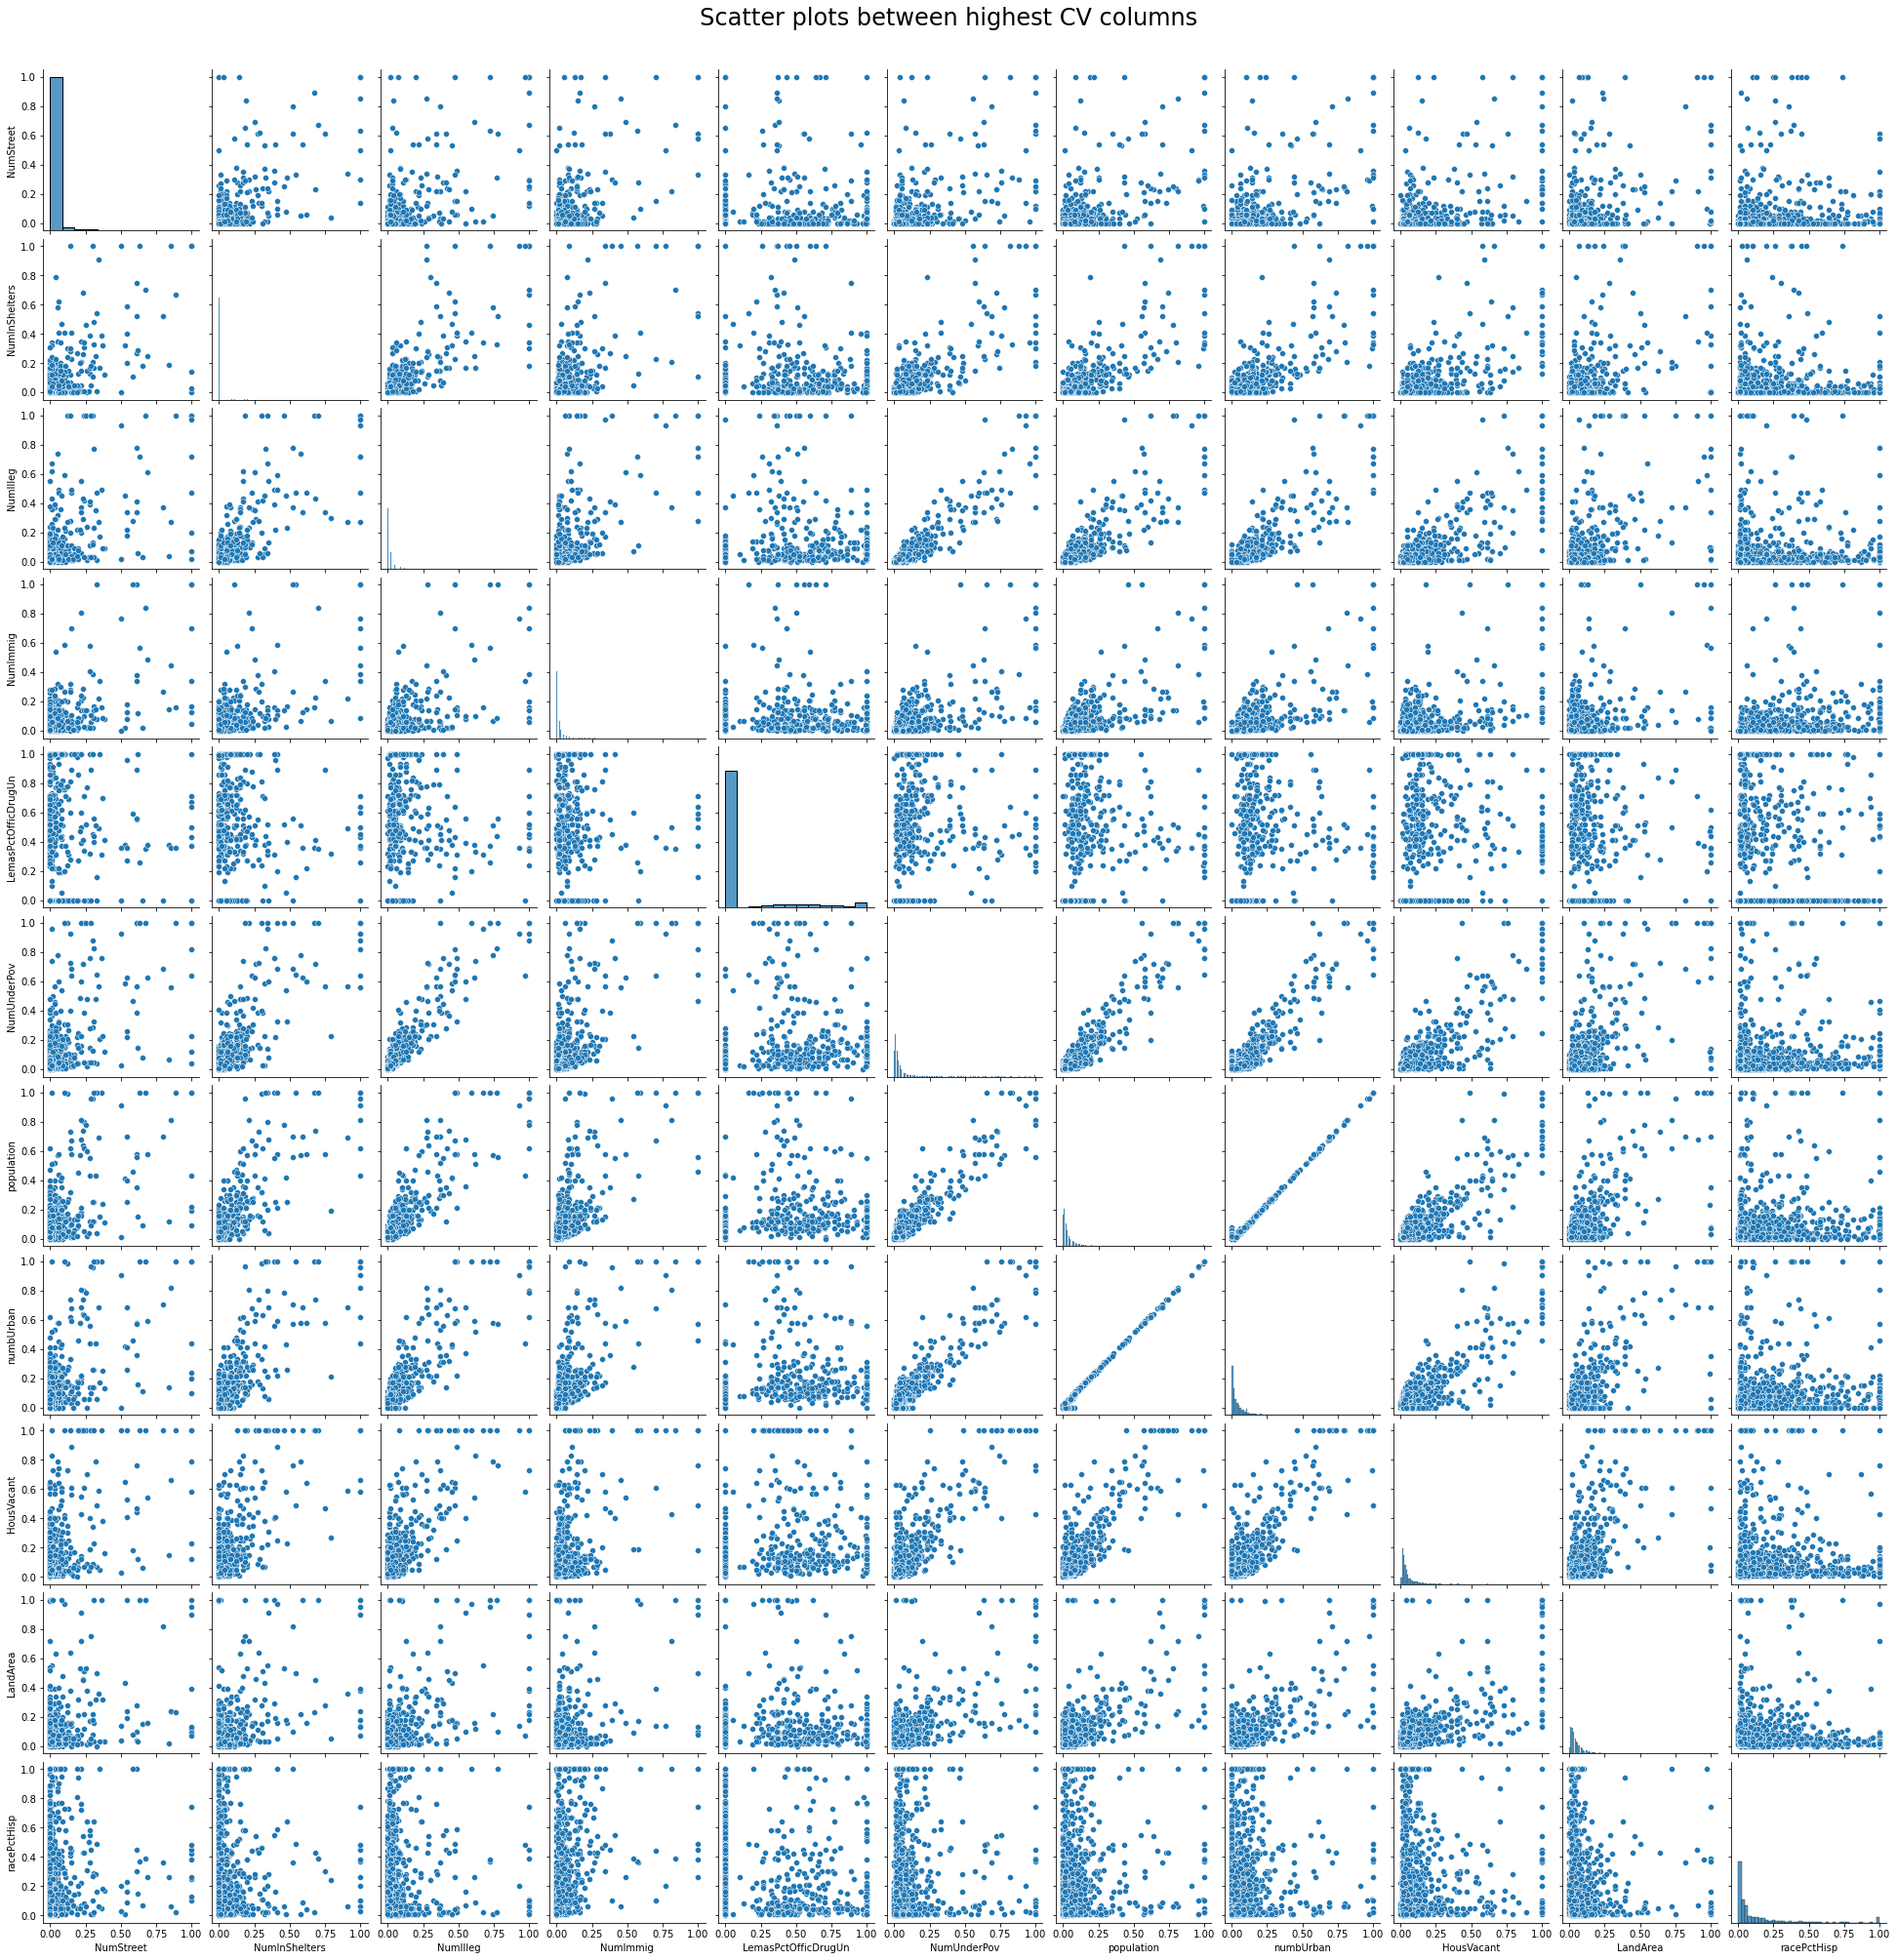

In [73]:
highest_CV_cols = highest_CV_features.index.tolist()
pair_plot = sns.pairplot(X_df[highest_CV_cols])
pair_plot.fig.suptitle("Scatter plots between highest CV columns", y=1.02, fontsize=24)
plt.show()

**Analysis:**

We cannot draw any conclusions about significance of highest CV features, just by the scatter plots. But, we could observe some positive correlation between the features numbUrban and population. 

#### Box plots

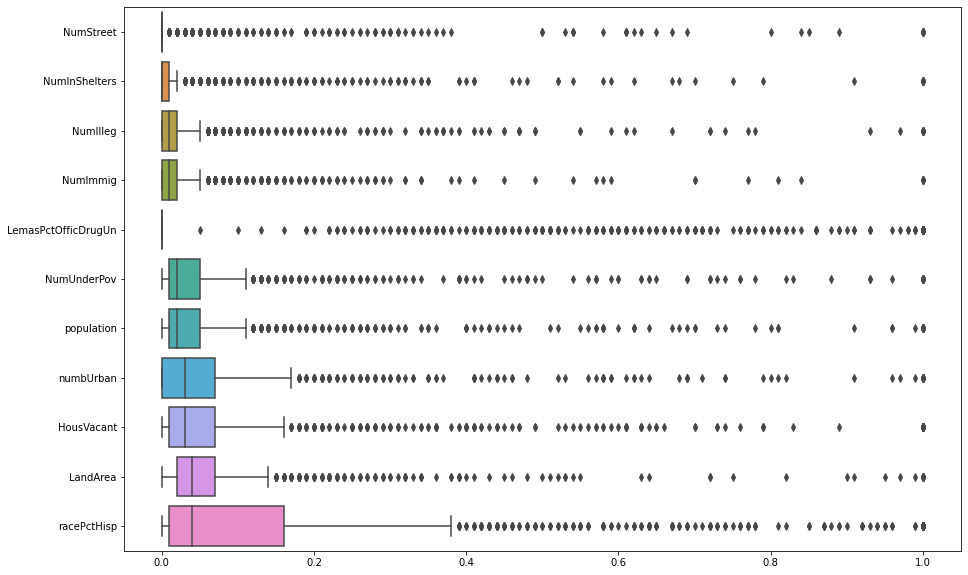

In [74]:
fig = plt.figure(figsize=(15, 10))
sns.boxplot(data=X_df[highest_CV_cols], orient="h")
plt.show()

### (f) Fit a linear model using least squares to the training set and report the test error.


#### Splitting imputed dataset into trainX, trainY, testX, testY

In [75]:
X_train = imp_train_df.drop(imp_train_df.columns[-1],axis=1)
y_train = imp_train_df[imp_train_df.columns[-1]]

X_test = imp_test_df.drop(imp_test_df.columns[-1],axis=1)
y_test = imp_test_df[imp_test_df.columns[-1]]

In [76]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print("Test error:",mean_squared_error(y_test,y_pred))
print("\nTest R^2:",r2_score(y_test, y_pred))

Test error: 0.017844644706157823

Test R^2: 0.6247601321388443


### (g) Fit a ridge regression model on the training set, with lambda chosen by cross-validation. Report the test error obtained.

In [78]:
# Here, lamdba is equal to alpha

split = KFold(5, shuffle=True, random_state=42)
alphas = [10 ** i for i in range(-5, 4)]
model = RidgeCV(alphas=alphas,cv=split)
model.fit(X_train, y_train)
best_alpha_value=model.alpha_
print("Best alpha value:",best_alpha_value)

re_fit = Ridge(alpha=best_alpha_value,random_state=42)
re_fit.fit(X_train,y_train)
y_pred = re_fit.predict(X_test)

print("\nTest error:",mean_squared_error(y_test,y_pred))
print("\nTest R^2:",r2_score(y_test, y_pred))

Best alpha value: 1.0

Test error: 0.017502306931091564

Test R^2: 0.6319588622674087


### (h) Fit a LASSO model on the training set, with lambda chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

#### Non-standardized features

In [80]:
# Here, lamdba is equal to alpha

split = KFold(5, shuffle=True, random_state=42)
alphas = [10 ** i for i in range(-5, 4)]
model = LassoCV(alphas=alphas,cv=split,random_state=42)
model.fit(X_train, y_train)
best_alpha_value = model.alpha_
print("Best alpha value:",best_alpha_value)

re_fit = Lasso(alpha=best_alpha_value,random_state=42)
re_fit.fit(X_train,y_train)
y_pred = re_fit.predict(X_test)

print("\nTest error:",mean_squared_error(y_test,y_pred))
print("\nTest R^2:",r2_score(y_test, y_pred))

selected_features = pd.Series(data=re_fit.coef_[re_fit.coef_!=0], index=X_test.columns[re_fit.coef_!=0])
print("\nThe number of features selected are:",len(selected_features))
print("\nFeatures selected:\n")
print(selected_features.to_string())

Best alpha value: 0.0001

Test error: 0.01758385221993978

Test R^2: 0.6302441156912807

The number of features selected are: 67

Features selected:

racepctblack             0.275387
racePctAsian            -0.014810
agePct12t21              0.078213
agePct12t29             -0.279285
agePct65up               0.011939
numbUrban               -0.023877
pctUrban                 0.040954
pctWWage                -0.097708
pctWFarmSelf             0.031823
pctWInvInc              -0.098302
pctWSocSec               0.046216
pctWPubAsst              0.042243
pctWRetire              -0.105850
whitePerCap             -0.065942
blackPerCap             -0.021036
indianPerCap            -0.032080
AsianPerCap              0.029011
OtherPerCap              0.024887
HispPerCap               0.024169
PctPopUnderPov          -0.144925
PctLess9thGrade         -0.024592
PctBSorMore              0.015077
PctEmploy                0.161049
PctEmplManu             -0.018688
PctOccupManu             0.020856


#### Standardized features

In [81]:
scaler = StandardScaler()

std_X_train = scaler.fit_transform(X_train)
std_X_test = scaler.transform(X_test)

std_X_train = pd.DataFrame(data=std_X_train, columns=X_train.columns)
std_X_test = pd.DataFrame(data=std_X_test, columns=X_test.columns)

In [83]:
# Here, lamdba is equal to alpha

split = KFold(5, shuffle=True, random_state=42)
alphas = [10 ** i for i in range(-5, 4)]
model = LassoCV(alphas=alphas,cv=split,random_state=42)
model.fit(std_X_train, y_train)
best_alpha_value = model.alpha_
print("Best alpha value:",best_alpha_value)

re_fit = Lasso(alpha=best_alpha_value,random_state=42)
re_fit.fit(std_X_train,y_train)
y_pred = re_fit.predict(std_X_test)

print("\nTest error:",mean_squared_error(y_test,y_pred))
print("\nTest R^2:",r2_score(y_test, y_pred))

selected_features = pd.Series(data=re_fit.coef_[re_fit.coef_!=0], index=std_X_train.columns[re_fit.coef_!=0])
print("\nThe number of features selected are:",len(selected_features))
print("\nFeatures selected:\n")
print(selected_features.to_string())

Best alpha value: 0.001

Test error: 0.01751870820952093

Test R^2: 0.6316139737223055

The number of features selected are: 55

Features selected:

population              -0.001318
racepctblack             0.067537
agePct12t21              0.005808
agePct12t29             -0.027356
pctUrban                 0.015397
pctWWage                -0.009828
pctWFarmSelf             0.003414
pctWInvInc              -0.015813
pctWSocSec               0.005282
pctWPubAsst              0.003295
pctWRetire              -0.014889
whitePerCap             -0.004651
blackPerCap             -0.003123
indianPerCap            -0.005016
AsianPerCap              0.004814
OtherPerCap              0.003792
HispPerCap               0.002939
PctPopUnderPov          -0.021052
PctLess9thGrade         -0.000525
PctEmploy                0.015509
MalePctDivorce           0.016556
MalePctNevMarr           0.015150
FemalePctDiv            -0.001859
PctKids2Par             -0.041631
PctYoungKids2Par        -0.008787
P

**Analysis:**

The features selected by Standardized model are less than the features selected by non-standardized model. There is not much difference in test errors of standardized and non-standardized datasets, both the errors are almost same for this dataset. Therefore, the standardized and non-standardized model performs similar in terms of test error.

### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [84]:
regr = LinearRegression()
mse = []
split = KFold(10, shuffle=True, random_state=42)
# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((len(X_train),1)), y_train, cv=split, scoring='neg_mean_squared_error').mean()    
mse.append(score)
for m in range(1,len(X_train.columns)+1):
    pca = PCA(n_components=m)
    X_train_red = pca.fit_transform(scale(X_train))
    score = -1*cross_val_score(regr, X_train_red, y_train, cv=split, scoring='neg_mean_squared_error').mean()  
    mse.append(score)
min_mse = min(mse)
best_M_value = mse.index(min_mse)
print("Best M value:",best_M_value)

pca = PCA(n_components=best_M_value)
X_train_red = pca.fit_transform(scale(X_train))
X_test_red = pca.transform(scale(X_test))
model = LinearRegression().fit(X_train_red,y_train)
y_pred = model.predict(X_test_red)

print("\nTest error:",mean_squared_error(y_test,y_pred))
print("\nTest R^2:",r2_score(y_test,y_pred))

Best M value: 77

Test error: 0.018362049436112242

Test R^2: 0.6138800678004472


### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine alpha (the regularization term) using cross-validation.

In [85]:
alphas = [10 ** i for i in range(-5, 4)]
model = xgb.XGBRegressor(max_depth=4,n_estimators=100)
parameters = {'reg_alpha':alphas}
grid_cv = GridSearchCV(estimator=model,param_grid=parameters,cv=10)
grid_cv.fit(X_train,y_train)
best_alpha_value = grid_cv.best_params_['reg_alpha']
print("Best alpha value:",best_alpha_value)

re_fit = xgb.XGBRegressor(max_depth=4,n_estimators=100,alpha=best_alpha_value)
re_fit.fit(X_train,y_train)
y_pred = re_fit.predict(X_test)
print("\nTest error:",mean_squared_error(y_test,y_pred))
print("\nTest R^2:", r2_score(y_test,y_pred))

Best alpha value: 0.1

Test error: 0.017729383769066517

Test R^2: 0.6271838564278893


### 2. Tree-Based Methods

### (a) Download the APS Failure data. The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

#### Loading train data

In [86]:
aps_train_df = pd.read_csv("../Data/aps_failure_training_set.csv",skiprows=20)
aps_train_df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


#### Loading test data

In [87]:
aps_test_df = pd.read_csv("../Data/aps_failure_test_set.csv",skiprows=20)
aps_test_df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,...,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,neg,81852,na,2130706432,892,0,0,0,0,0,...,632658,273242,510354,373918,349840,317840,960024,25566,0,0
15996,neg,18,0,52,46,8,26,0,0,0,...,266,44,46,14,2,0,0,0,0,0
15997,neg,79636,na,1670,1518,0,0,0,0,0,...,806832,449962,778826,581558,375498,222866,358934,19548,0,0
15998,neg,110,na,36,32,0,0,0,0,0,...,588,210,180,544,1004,1338,74,0,0,0


In [88]:
aps_df = pd.concat([aps_train_df,aps_test_df],ignore_index=True)
aps_df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,neg,81852,na,2130706432,892,0,0,0,0,0,...,632658,273242,510354,373918,349840,317840,960024,25566,0,0
75996,neg,18,0,52,46,8,26,0,0,0,...,266,44,46,14,2,0,0,0,0,0
75997,neg,79636,na,1670,1518,0,0,0,0,0,...,806832,449962,778826,581558,375498,222866,358934,19548,0,0
75998,neg,110,na,36,32,0,0,0,0,0,...,588,210,180,544,1004,1338,74,0,0,0


### (b) Data Preparation

### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

#### Techniques used for dealing with data with missing values

There are mainly two types of imputation methods to deal with missing values: "Univariate" and "Multivariate".

- Univariate: Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located.

- Multivariate: Multivariate methods include single value regression analysis, monotonic imputation and chained equations or the Markov chain Monte Carlo (MCMC) method. It is the more sophisticated way of data imputation but more time-consuming.

I have used Univariate method "mean" to impute the missing values in the dataset.

In [90]:
aps_df = aps_df.replace('na',np.nan)
missing_col_idx = aps_df.columns[aps_df.isnull().any()]
print('\033[1m'+"There are missing values in these columns: \n"+'\033[0m')
print(missing_col_idx,"\n")

# Count of missing values in each column

print('\033[1m'+"Count of missing values in each column: \n"+'\033[0m')
print(aps_df[missing_col_idx].isna().sum())

There are missing values in these columns: 

Index(['ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001',
       'ag_002', 'ag_003', 'ag_004',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=169) 

Count of missing values in each column: 

ab_000    58692
ac_000     4261
ad_000    18842
ae_000     3190
af_000     3190
          ...  
ee_007      863
ee_008      863
ee_009      863
ef_000     3486
eg_000     3485
Length: 169, dtype: int64


#### Imputing NaN values by mean of the columns

In [91]:
aps_imp_X = aps_df[aps_df.columns[1:]]
aps_imp_y = aps_df[aps_df.columns[0]]

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
aps_imp_X = pd.DataFrame(imputer.fit_transform(aps_imp_X), columns=aps_imp_X.columns)
aps_imp_X

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.72556,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.72556,0.000000e+00,150629.962105,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.72556,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.00000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.72556,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,81852.0,0.72556,2.130706e+09,892.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
75996,18.0,0.00000,5.200000e+01,46.000000,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
75997,79636.0,0.72556,1.670000e+03,1518.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
75998,110.0,0.72556,3.600000e+01,32.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


### ii. For each of the 170 features, calculate the coefficient of variation CV = s/m where s is sample standard deviation and m is sample mean.

In [92]:
cv =  lambda x: np.std(x) / np.mean(x)
cv_result = aps_imp_X.apply(cv,axis=0)
print("The number of features are:",len(cv_result))
print(cv_result.to_string())

The number of features are: 170
aa_000      4.328579
ab_000      2.178258
ac_000      2.167639
ad_000    206.720140
ae_000     22.293524
af_000     18.208896
ag_000     91.460052
ag_001     42.084066
ag_002     17.625793
ag_003      8.753242
ag_004      5.475080
ag_005      2.964210
ag_006      2.352572
ag_007      2.812479
ag_008      6.274939
ag_009     32.166846
ah_000      2.315525
ai_000     18.506186
aj_000     43.144196
ak_000     78.622470
al_000      9.111931
am_0        9.067136
an_000      2.254212
ao_000      2.276100
ap_000      3.085865
aq_000      2.853453
ar_000     10.569133
as_000    113.882006
at_000     23.186907
au_000     86.085071
av_000      5.730448
ax_000      3.859010
ay_000     40.902250
ay_001     49.248311
ay_002     38.342067
ay_003     28.329849
ay_004     33.039915
ay_005     12.008982
ay_006      3.021902
ay_007      3.249874
ay_008      3.943755
ay_009     77.460592
az_000      9.019810
az_001      7.374919
az_002     12.050349
az_003      7.565519
az

### iii. Plot a correlation matrix for your features using pandas or any other tool.

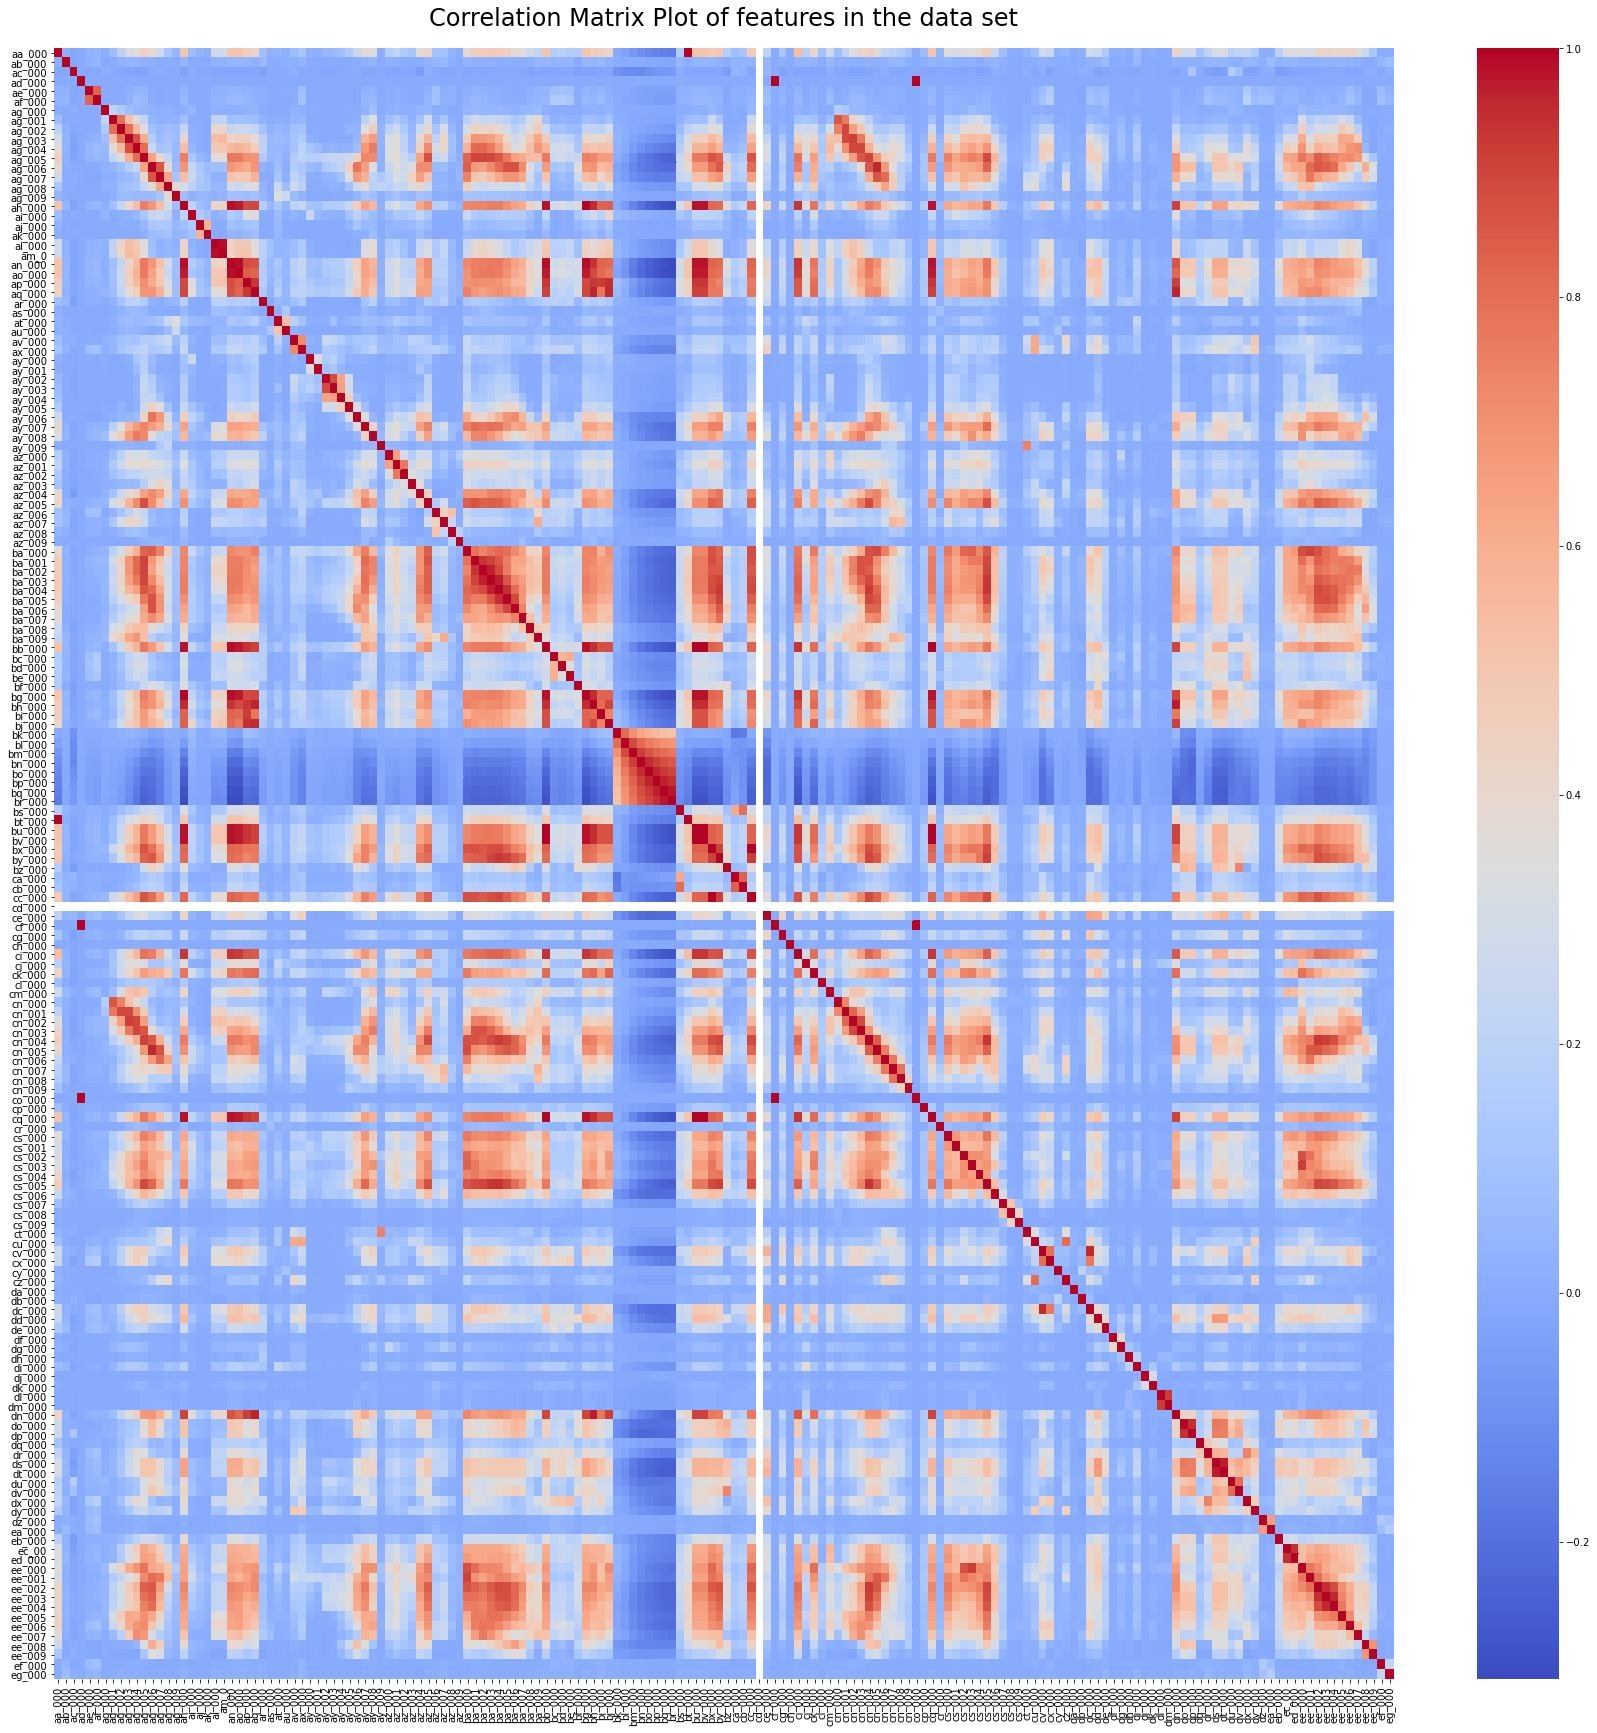

In [93]:
cor_mtx = aps_imp_X.corr()
fig = plt.figure(figsize=(30, 30))
sns.heatmap(cor_mtx, xticklabels=cor_mtx.columns, yticklabels=cor_mtx.columns, cmap='coolwarm')
plt.title("Correlation Matrix Plot of features in the data set",y=1.01,fontsize=24)
plt.show()

### iv. Pick sqrt(170) features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [94]:
num_of_features = int(np.floor(np.sqrt(170)))
print("The number of features:",num_of_features)
highest_CV_features = cv_result.sort_values(ascending=False)[:num_of_features]
print("\nThe highest CV features are as follows: \n")
print(highest_CV_features.to_string())

The number of features: 13

The highest CV features are as follows: 

cf_000    207.268910
co_000    206.874768
ad_000    206.720140
cs_009    192.521344
dj_000    122.127349
as_000    113.882006
dh_000    112.651709
df_000    111.368933
ag_000     91.460052
au_000     86.085071
ak_000     78.622470
az_009     77.999043
ay_009     77.460592


#### Scatter plots

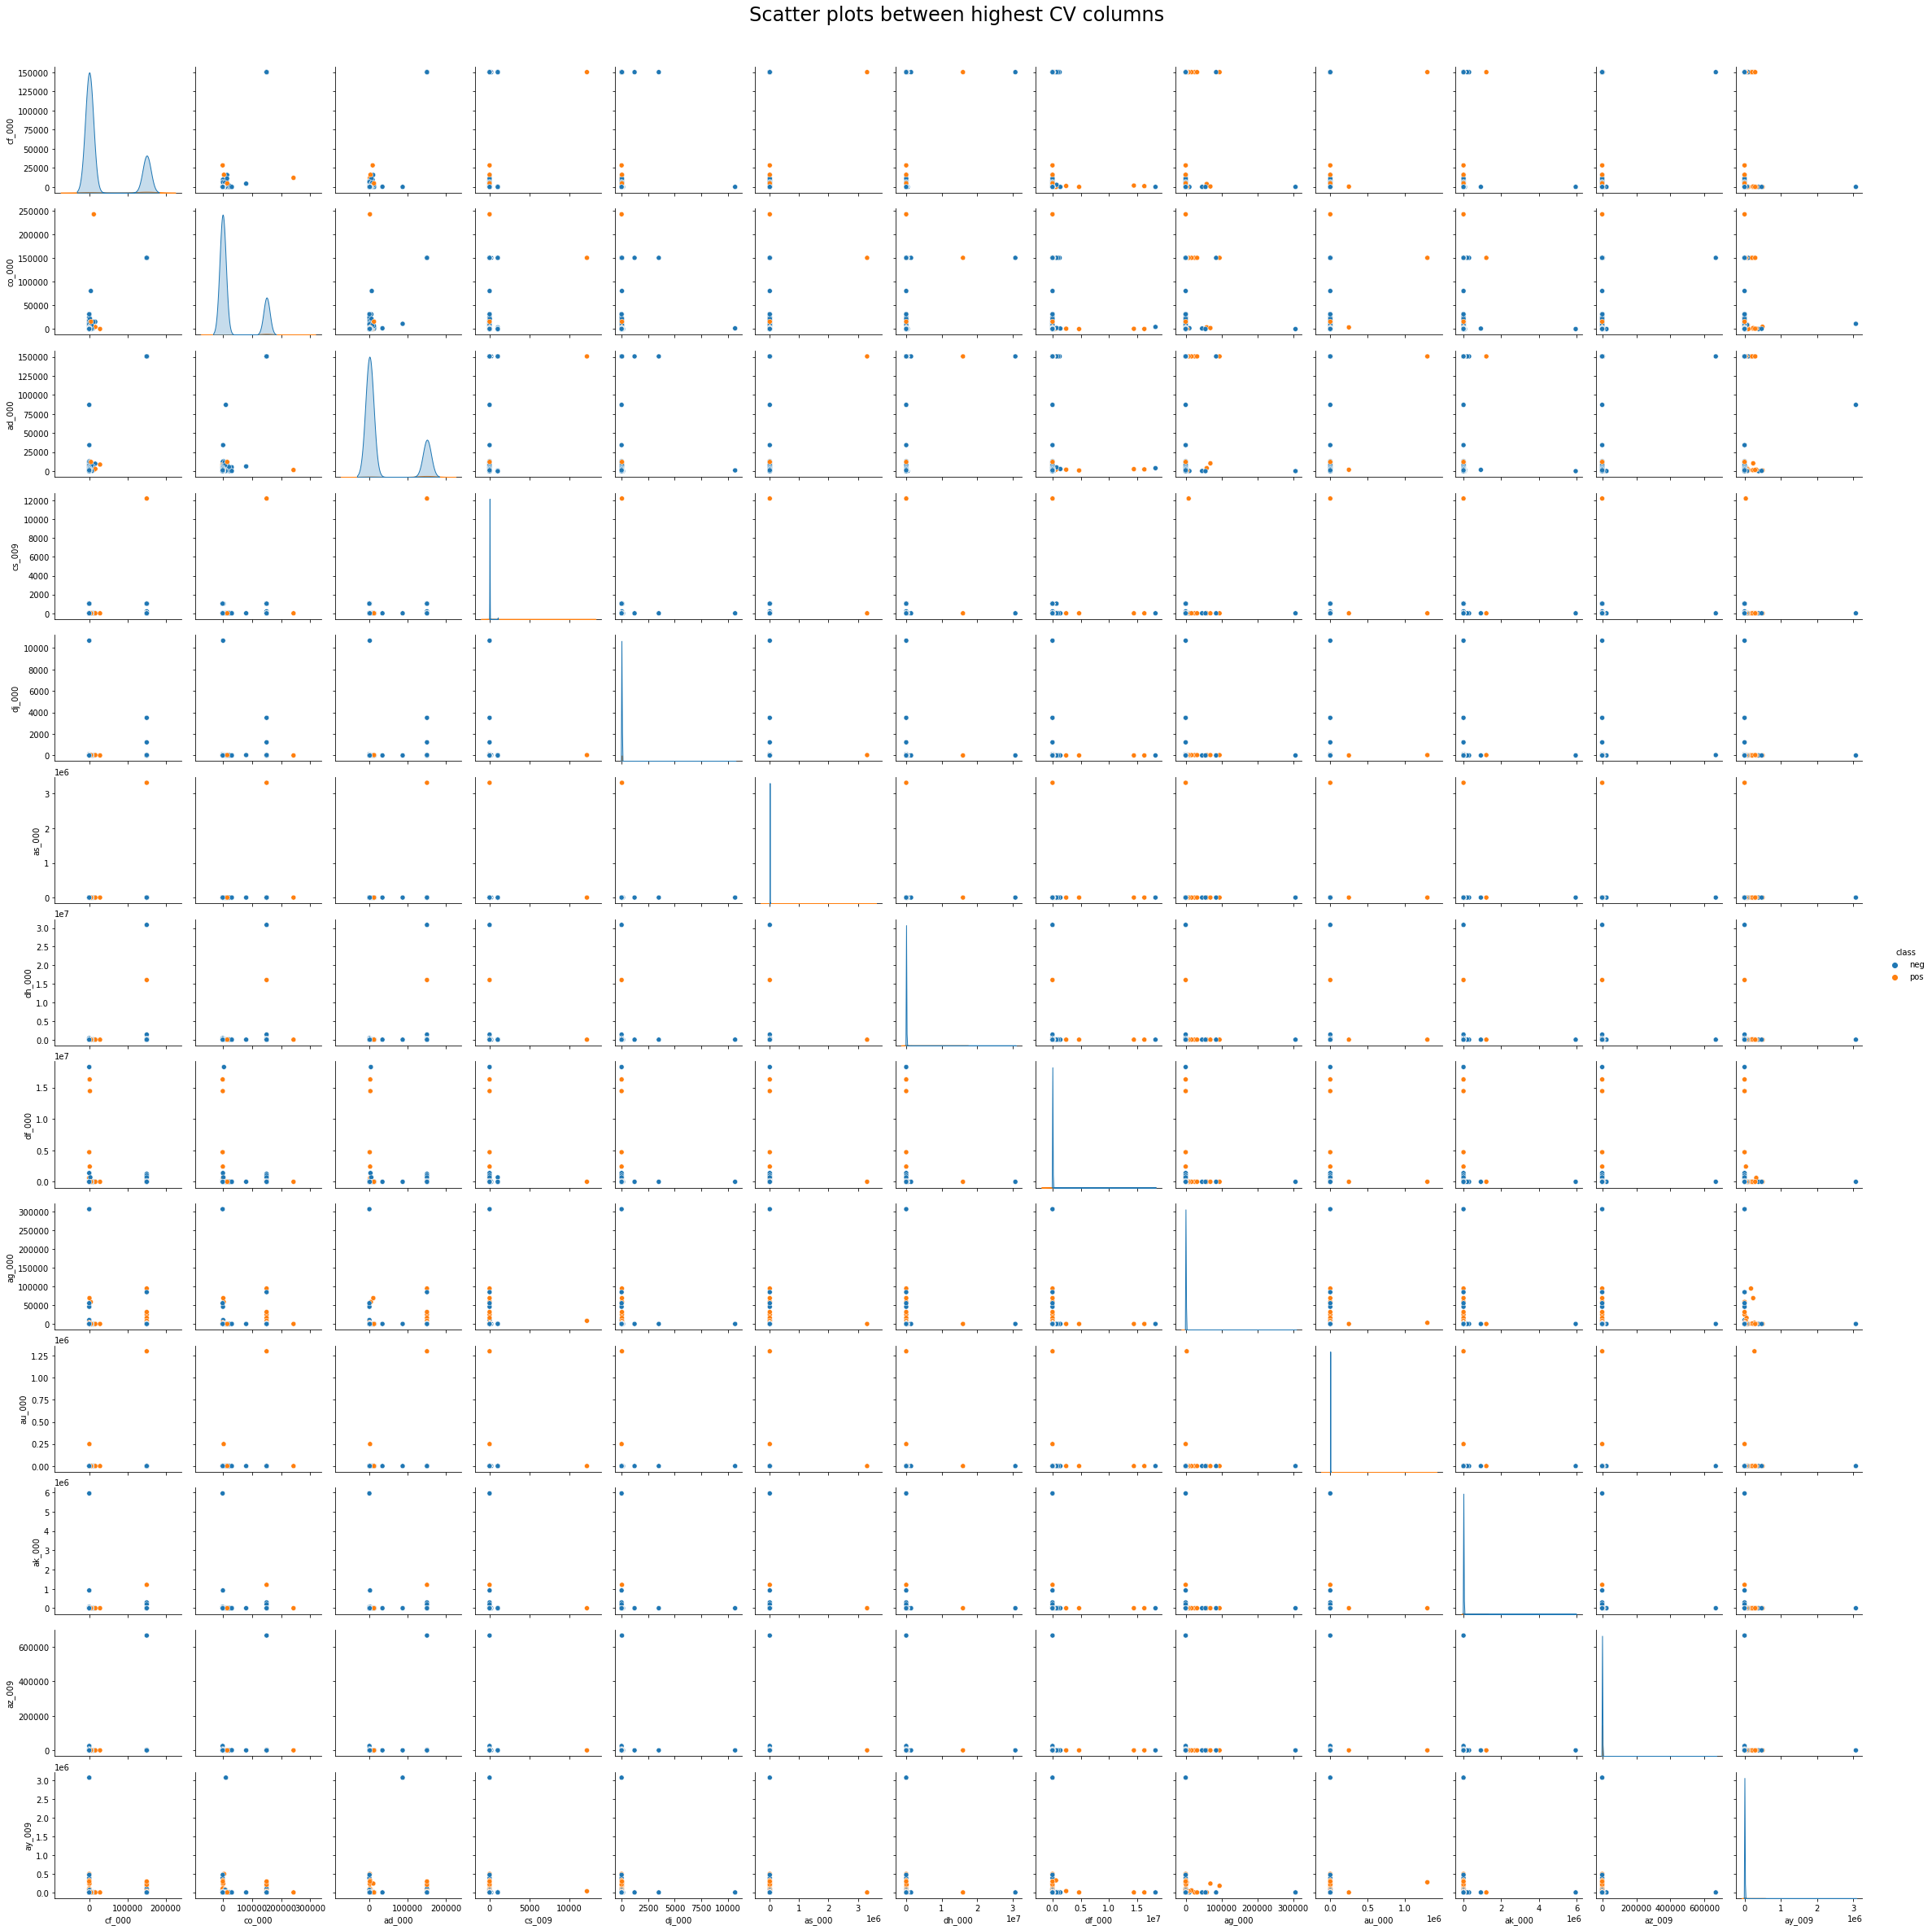

In [95]:
highest_CV_cols = highest_CV_features.index.tolist()
aps_scatter = aps_imp_X[highest_CV_cols]
aps_scatter['class'] = aps_imp_y
pair_plot = sns.pairplot(aps_scatter.sample(frac=0.1),hue='class')
pair_plot.fig.suptitle("Scatter plots between highest CV columns", y=1.02, fontsize=24)
plt.show()

#### Box plots

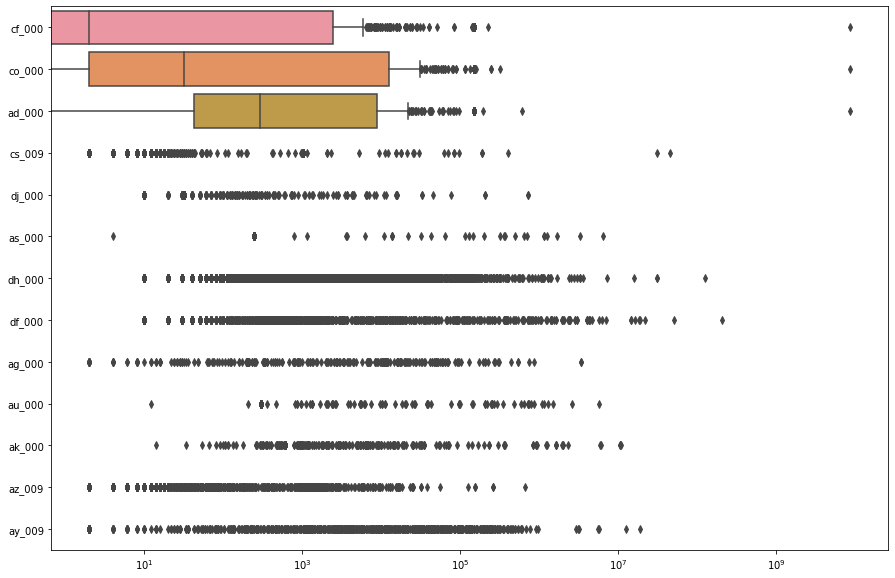

In [96]:
fig = plt.figure(figsize=(15, 10))
box_plot = sns.boxplot(data=aps_imp_X[highest_CV_cols], orient="h")
box_plot.set(xscale="log")
plt.show()

**Analysis:**

It is difficult to draw any conclusions about significance of highest CV features, just by the scatter plots. I have used the log scale for boxplot to see the distribution better.

### v. Determine the number of positive and negative data. Is this data set imbalanced?

In [97]:
neg_data = aps_imp_y.value_counts()['neg']
pos_data = aps_imp_y.value_counts()['pos']
print("The number of positive data:",pos_data)
print("\nThe number of negative data:",neg_data)

The number of positive data: 1375

The number of negative data: 74625


**Analysis:**

Yes, as observed the positive data is very less than the negative data. Thus, the dataset is highly imbalanced. 

### (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

#### Splitting imputed aps data into trainX, trainY, testX, testY and replacing "neg" as 0 and "pos" as 1

In [119]:
aps_imp_y = pd.DataFrame(aps_imp_y, columns=['class'])

aps_imp_y.loc[aps_imp_y['class']=='neg','class']=0
aps_imp_y.loc[aps_imp_y['class']=='pos','class']=1

aps_X_train = aps_imp_X.iloc[0:60000]
aps_y_train = aps_imp_y.iloc[0:60000]
aps_X_test = aps_imp_X.iloc[60000:]
aps_y_test = aps_imp_y.iloc[60000:]

aps_X_train = aps_X_train.astype('float')
aps_y_train = aps_y_train.astype('int')
aps_X_test = aps_X_test.astype('float')
aps_y_test = aps_y_test.astype('int')

#### Model summary on train dataset

In [100]:
model = RandomForestClassifier(n_estimators=100,oob_score=True,random_state=42,max_depth=5,n_jobs=-1)
model.fit(aps_X_train,aps_y_train)
y_pred = model.predict(aps_X_train)
y_prob = model.predict_proba(aps_X_train)

Confusion Matrix:

[[58975    25]
 [  427   573]]

The misclassification in the set: 452

Area under the curve: 0.9862446779661015

The accuracy score: 0.9924666666666667

The error obtained: 0.007533333333333281

OOB Score: 0.9907666666666667


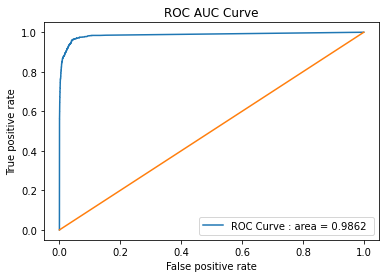

In [101]:
model_summary(aps_y_train,y_pred,y_prob[:,1])
print("\nOOB Score:",model.oob_score_)

#### Model summary on test dataset

Confusion Matrix:

[[15611    14]
 [  176   199]]

The misclassification in the set: 190

Area under the curve: 0.9941467306666667

The accuracy score: 0.988125

The error obtained: 0.011874999999999969

OOB Score: 0.9907666666666667


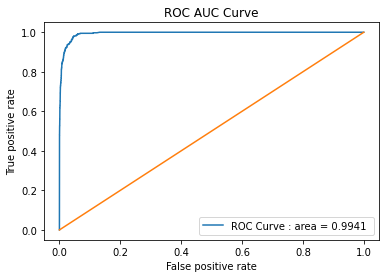

In [102]:
y_pred = model.predict(aps_X_test)
y_prob = model.predict_proba(aps_X_test)
model_summary(aps_y_test,y_pred,y_prob[:,1])
print("\nOOB Score:",model.oob_score_)

#### OOB error and test error comparison

In [103]:
print("The Out of Bag (OOB) error estimate for the random forset:",1 - model.oob_score_)
print("\nThe test error:",1 - accuracy_score(aps_y_test,y_pred))

The Out of Bag (OOB) error estimate for the random forset: 0.009233333333333316

The test error: 0.011874999999999969


**Analysis:**

From the above results, it is observed that the Out of Bag (OOB) error estimate is slightly less than the test error.

### (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

Random forest is not a good choice when we have imbalanced data. Random forest is buit on multiple decision trees, each of them uses a bag of the datapoints and features. Therefore, a bag of datapoints might contain a few or none of the minority class points which would make some decision trees biased.

The methods to overcome imbalance in random forests are as follows:

1. Random Forest With Class Weighting - A simple technique for modifying a decision tree for imbalanced classification is to change the weight that each class has when calculating the “impurity” score of a chosen split point. This can be achieved by setting the class_weight argument on the RandomForestClassifier class.
2. Random Forest With Bootstrap Class Weighting - Given that each decision tree is constructed from a bootstrap sample (e.g. random selection with replacement), the class distribution in the data sample will be different for each tree. As such, it might be interesting to change the class weighting based on the class distribution in each bootstrap sample, instead of the entire training dataset. This can be achieved by setting the class_weight argument to the value ‘balanced_subsample‘.
3. Random Forest With Random Undersampling - Another useful modification to random forest is to perform data resampling on the bootstrap sample in order to explicitly change the class distribution. The BalancedRandomForestClassifier class from the imbalanced-learn library implements this and performs random undersampling of the majority class in reach bootstrap sample.

I have used first method "Random Forest With Class Weighting" to deal with imbalance in dataset.

#### Model summary on train dataset

Confusion Matrix:

[[56619  2381]
 [   31   969]]

The misclassification in the set: 2412

Area under the curve: 0.9899458813559322

The accuracy score: 0.9598

The error obtained: 0.040200000000000014

OOB Score: 0.9585


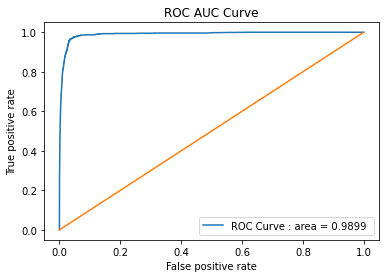

In [104]:
model = RandomForestClassifier(n_estimators=100,oob_score=True,random_state=42,class_weight='balanced',max_depth=5,n_jobs=-1)
model.fit(aps_X_train,aps_y_train)
y_pred = model.predict(aps_X_train)
y_prob = model.predict_proba(aps_X_train)
model_summary(aps_y_train,y_pred,y_prob[:,1])
print("\nOOB Score:",model.oob_score_)

#### Model summary on test dataset

Confusion Matrix:

[[15014   611]
 [   13   362]]

The misclassification in the set: 624

Area under the curve: 0.9898740053333333

The accuracy score: 0.961

The error obtained: 0.039000000000000035

OOB Score: 0.9585


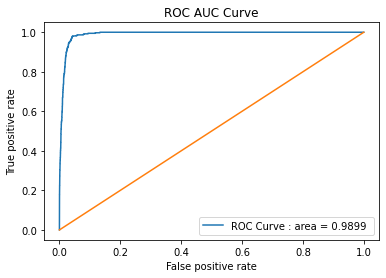

In [105]:
y_pred = model.predict(aps_X_test)
y_prob = model.predict_proba(aps_X_test)
model_summary(aps_y_test,y_pred,y_prob[:,1])
print("\nOOB Score:",model.oob_score_)

#### OOB error and test error comparison

In [106]:
print("The Out of Bag (OOB) error estimate for the random forset:",1 - model.oob_score_)
print("\nThe test error:",1 - accuracy_score(aps_y_test,y_pred))

The Out of Bag (OOB) error estimate for the random forset: 0.04149999999999998

The test error: 0.039000000000000035


**Analysis**

From the above results, it is observed that the Out of Bag (OOB) error estimate is slightly greater than the test error.

Comparing results of 2.c and 2.d we can say that: 
- The overall accuracy of training and test set is higher in 2.c than 2.d. 
- However in 2.c, the 'pos' class datapoints are highly miss-classified due to class imbalance. In 2.d, the 'pos' class label miss-classification is very low i.e. the model now can classify the minority class in a better way. 

Thus, by compensating the class imbalance, our accuracy decreases but our prediction on 'pos' class (minority class) increases.

### e) Model Trees

#### Write train and test files for weka loading

In [108]:
aps_y_train = to_String_label(aps_y_train)
aps_y_test = to_String_label(aps_y_test)
aps_train = pd.concat([aps_X_train,aps_y_train],axis=1)
aps_test = pd.concat([aps_X_test,aps_y_test],axis=1)
aps_train.to_csv('../Data/weka_aps_train.csv',index=False)
aps_test.to_csv('../Data/weka_aps_test.csv',index=False)

In [109]:
import weka.core.jvm as jvm
jvm.start(packages=True)

import weka.core.converters as convert
from weka.classifiers import Evaluation, Classifier, FilteredClassifier
from weka.core.classes import Random
import weka.plot.classifiers as plcls
from weka.filters import Filter

weka_train_df = convert.load_any_file('../Data/weka_aps_train.csv')
weka_test_df = convert.load_any_file('../Data/weka_aps_test.csv')
weka_train_df.class_is_last()
weka_test_df.class_is_last()

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


#### 5 fold cross validation

In [30]:
cls = Classifier(classname="weka.classifiers.trees.LMT")

evaluation = Evaluation(weka_train_df)
evaluation.crossvalidate_model(classifier=cls,data=weka_train_df,num_folds=5,rnd=Random(1))

print("Confusion Matrix:\n")
print(evaluation.matrix())
print("\nSummary:")
print(evaluation.summary(),'\n')
print(evaluation.class_details())

Confusion Matrix:

=== Confusion Matrix ===

     a     b   <-- classified as
 58852   148 |     a = neg
   352   648 |     b = pos


Summary:

Correctly Classified Instances       59500               99.1667 %
Incorrectly Classified Instances       500                0.8333 %
Kappa statistic                          0.7174
Mean absolute error                      0.0119
Root mean squared error                  0.0825
Relative absolute error                 36.3706 %
Root relative squared error             64.4397 %
Total Number of Instances            60000     
 

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.352    0.994      0.997    0.996      0.722    0.966     0.998     neg
                 0.648    0.003    0.814      0.648    0.722      0.722    0.966     0.757     pos
Weighted Avg.    0.992    0.346    0.991      0.992    0.991      0.722    0.966     0.994  

In [31]:
cls.build_classifier(weka_train_df)

#### Training data

Confusion Matrix:

[[58935    65]
 [  258   742]]

The misclassification in the set: 323

Area under the curve: 0.988252152542373

The accuracy score: 0.9946166666666667

The error obtained: 0.0053833333333332956


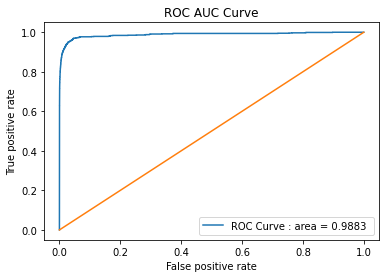

In [32]:
train_y_pred = []
train_y_prob = []
for instance in weka_train_df:
    train_y_pred.append(cls.classify_instance(instance))
    train_y_prob.append(cls.distribution_for_instance(instance))

train_y_pred = np.array(train_y_pred).astype("int")
train_y_pred[train_y_pred == '0.0'] = 0
train_y_pred[train_y_pred == '1.0'] = 1  
aps_y_train = to_Numeric_label(aps_y_train)
train_y_prob = np.array(train_y_prob)
model_summary(aps_y_train, train_y_pred, train_y_prob[:, 1])

#### Test data

Confusion Matrix:

[[15577    48]
 [  106   269]]

The misclassification in the set: 154

Area under the curve: 0.9724980906666665

The accuracy score: 0.990375

The error obtained: 0.009624999999999995


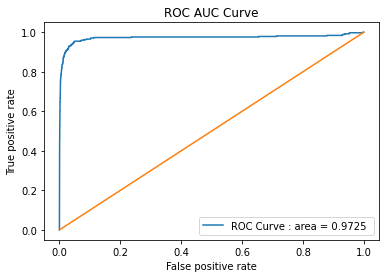

In [33]:
test_y_pred = []
test_y_prob = []
for instance in weka_test_df:
    test_y_pred.append(cls.classify_instance(instance))
    test_y_prob.append(cls.distribution_for_instance(instance))

test_y_pred = np.array(test_y_pred).astype("int")
test_y_pred[test_y_pred == '0.0'] = 0
test_y_pred[test_y_pred == '1.0'] = 1  
aps_y_test = to_Numeric_label(aps_y_test)
test_y_prob = np.array(test_y_prob)
model_summary(aps_y_test, test_y_pred, test_y_prob[:, 1])

Comparison of train and test errors:

- The train error is 0.00538 and test error is 0.00962. There is not much difference in both the errors, although train error is slightly less than test error.

### (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE.

#### Pre-process the data to compensate for class imbalance using SMOTE

In [34]:
SMOTE = Filter(classname="weka.filters.supervised.instance.SMOTE", options=["-S", "0"])
cls_smote = Classifier(classname="weka.classifiers.trees.LMT")

fc = FilteredClassifier()
fc.filter = SMOTE
fc.classifier = cls_smote

evl = Evaluation(weka_train_df)
evl.crossvalidate_model(fc, weka_train_df, 5, Random(1))

print("Confusion Matrix:\n")
print(evl.matrix())
print("\nSummary:")
print(evl.summary(),'\n')
print(evl.class_details())

Confusion Matrix:

=== Confusion Matrix ===

     a     b   <-- classified as
 58771   229 |     a = neg
   303   697 |     b = pos


Summary:

Correctly Classified Instances       59468               99.1133 %
Incorrectly Classified Instances       532                0.8867 %
Kappa statistic                          0.7193
Mean absolute error                      0.014 
Root mean squared error                  0.0846
Relative absolute error                 42.6438 %
Root relative squared error             66.1223 %
Total Number of Instances            60000     
 

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.996    0.303    0.995      0.996    0.995      0.720    0.958     0.997     neg
                 0.697    0.004    0.753      0.697    0.724      0.720    0.958     0.747     pos
Weighted Avg.    0.991    0.298    0.991      0.991    0.991      0.720    0.958     0.993  

In [35]:
fc.build_classifier(weka_train_df)

#### Training data

Confusion Matrix:

[[58922    78]
 [  173   827]]

The misclassification in the set: 251

Area under the curve: 0.9905698983050848

The accuracy score: 0.9958166666666667

The error obtained: 0.004183333333333317


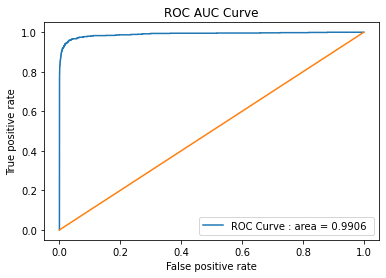

In [36]:
train_y_pred = []
train_y_prob = []
for instance in weka_train_df:
    train_y_pred.append(fc.classify_instance(instance))
    train_y_prob.append(fc.distribution_for_instance(instance))

train_y_pred = np.array(train_y_pred).astype("int")
train_y_pred[train_y_pred == '0.0'] = 0
train_y_pred[train_y_pred == '1.0'] = 1  
aps_y_train = to_Numeric_label(aps_y_train)
train_y_prob = np.array(train_y_prob)
model_summary(aps_y_train, train_y_pred, train_y_prob[:, 1])

#### Test data

Confusion Matrix:

[[15573    52]
 [   88   287]]

The misclassification in the set: 140

Area under the curve: 0.9687944533333334

The accuracy score: 0.99125

The error obtained: 0.008750000000000036


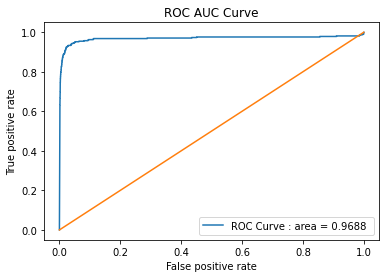

In [37]:
test_y_pred = []
test_y_prob = []
for instance in weka_test_df:
    test_y_pred.append(fc.classify_instance(instance))
    test_y_prob.append(fc.distribution_for_instance(instance))

test_y_pred = np.array(test_y_pred).astype("int")
test_y_pred[test_y_pred == '0.0'] = 0
test_y_pred[test_y_pred == '1.0'] = 1  
aps_y_test = to_Numeric_label(aps_y_test)
test_y_prob = np.array(test_y_prob)
model_summary(aps_y_test, test_y_pred, test_y_prob[:, 1])

**Analysis**

Comparison of train and test errors:

- The train error is 0.00418 and test error is 0.00875. There is not much difference in both the errors, although train error is slightly less than test error.

Comparison of uncompensated case with SMOTE:

- We can observe that the 'pos' class (minority) were miss-classified more with class imbalance (106/375). But when we used SMOTE to remove imbalance, the 'pos' class (minority) were miss-classified less (88/375). Thus, by using SMOTE we can now predict the 'pos' class (minority) in a better way.

In [110]:
jvm.stop()

### References 

1. https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data
2. https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well
3. http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html
4. https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
5. https://fracpete.github.io/python-weka-wrapper/examples.html
6. https://fracpete.github.io/python-weka-wrapper/api.html#classifiers
7. https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/